# Setting Up Environment

In [96]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords


from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.layers import Flatten, Embedding, GlobalMaxPooling1D, Conv1D, LSTM
from sklearn.model_selection import train_test_split

# Loading Dataset

In [97]:
crude_oil_news = pd.read_csv('data.csv')

In [98]:
crude_oil_news.shape

(71258, 2)

In [99]:
crude_oil_news.head(5)

,News,Prediction
0,why traders playing oil like its 2010 are get...,INCREASE
1,oil markets prove resilient in aftermath of i...,INCREASE
2,with oil prices poised to trend higher in 202...,INCREASE
3,us sanctions on iran will boost middle east e...,INCREASE
4,us crude oil inventories fall more than expec...,INCREASE


In [100]:
crude_oil_news.isnull().values.any()

False

<AxesSubplot:xlabel='Prediction', ylabel='count'>

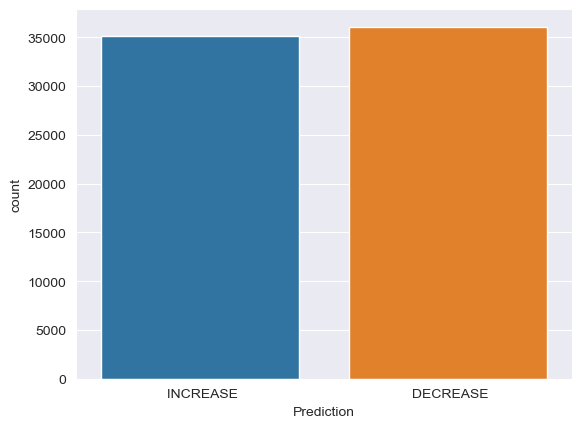

In [101]:
import seaborn as sns
sns.countplot(x='Prediction', data=c<AxesSubplot:xlabel='Prediction', ylabel='count'>rude_oil_news)

# Data Preprocessing

In [102]:
crude_oil_news['News'][2]

' with oil prices poised to trend higher in 2020  can royal dutch shells revenue recover'

In [103]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [104]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neram\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [105]:
def preprocessing_text(sen):
    sentence = sen.lower()

    sentence = remove_tags(sentence)

    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    sentence = re.sub(r'\s+', ' ', sentence)

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [106]:
X = []
sentences = list(crude_oil_news['News'])
for sen in sentences:
    X.append(preprocessing_text(sen))

In [107]:
y = crude_oil_news['Prediction']

y = np.array(list(map(lambda x: 1 if x==" INCREASE" else 0, y)))
np.asarray(y)


array([1, 1, 1, ..., 0, 0, 0])

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Preparing Embedding Layer

In [109]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [110]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

12197

In [111]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [112]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [113]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [114]:
embedding_matrix.shape

(12197, 100)

# Model Training

## Simple Neural Network

In [115]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [116]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          1219700   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_10 (Dense)            (None, 1)                 10001     
                                                                 
Total params: 1,229,701
Trainable params: 10,001
Non-trainable params: 1,219,700
_________________________________________________________________
None


In [117]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
357/357 [==============================] - 2s 4ms/step - loss: 0.6904 - acc: 0.5327 - val_loss: 0.6858 - val_acc: 0.5417
Epoch 2/50
357/357 [==============================] - 1s 4ms/step - loss: 0.6786 - acc: 0.5648 - val_loss: 0.6850 - val_acc: 0.5516
Epoch 3/50
357/357 [==============================] - 2s 4ms/step - loss: 0.6745 - acc: 0.5726 - val_loss: 0.6846 - val_acc: 0.5545
Epoch 4/50
357/357 [==============================] - 2s 4ms/step - loss: 0.6715 - acc: 0.5797 - val_loss: 0.6839 - val_acc: 0.5595
Epoch 5/50
357/357 [==============================] - 1s 4ms/step - loss: 0.6698 - acc: 0.5817 - val_loss: 0.6843 - val_acc: 0.5584
Epoch 6/50
357/357 [==============================] - 1s 4ms/step - loss: 0.6684 - acc: 0.5847 - val_loss: 0.6835 - val_acc: 0.5563
Epoch 7/50
357/357 [==============================] - 1s 4ms/step - loss: 0.6675 - acc: 0.5839 - val_loss: 0.6833 - val_acc: 0.5618
Epoch 8/50
357/357 [==============================] - 2s 4ms/step - loss: 0.

In [118]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

446/446 [==============================] - 1s 2ms/step - loss: 0.6854 - acc: 0.5655


In [119]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Test Score: 0.6853570938110352
Test Accuracy: 0.5654644966125488


In [120]:
prediction = snn_model.predict(X_test)

446/446 [==============================] - 1s 2ms/step


In [121]:
prediction

array([[0.50441325],
       [0.28272322],
       [0.48595357],
       ...,
       [0.5848258 ],
       [0.363974  ],
       [0.44458365]], dtype=float32)

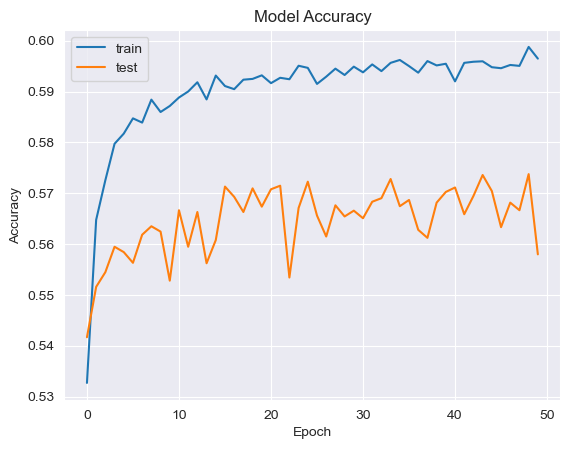

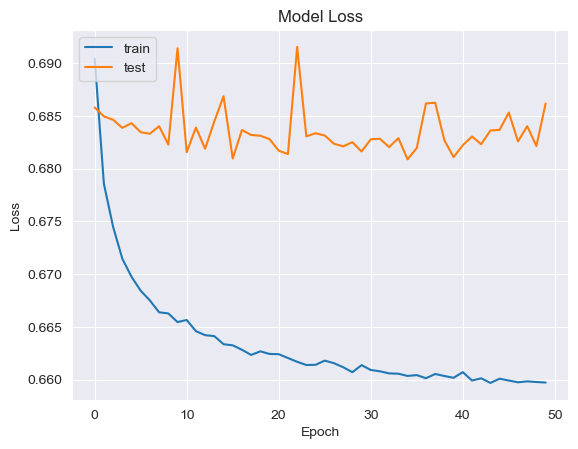

In [122]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [123]:
from keras.layers import Dropout

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())

# Add additional layers
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(1, activation='sigmoid'))

In [124]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          1219700   
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                      

In [125]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
357/357 [==============================] - 11s 29ms/step - loss: 0.6930 - acc: 0.5146 - val_loss: 0.6841 - val_acc: 0.5481
Epoch 2/6
357/357 [==============================] - 10s 28ms/step - loss: 0.6708 - acc: 0.5802 - val_loss: 0.6492 - val_acc: 0.6245
Epoch 3/6
357/357 [==============================] - 10s 28ms/step - loss: 0.5936 - acc: 0.6782 - val_loss: 0.5823 - val_acc: 0.6889
Epoch 4/6
357/357 [==============================] - 10s 28ms/step - loss: 0.4762 - acc: 0.7710 - val_loss: 0.5201 - val_acc: 0.7398
Epoch 5/6
357/357 [==============================] - 10s 27ms/step - loss: 0.3672 - acc: 0.8346 - val_loss: 0.4515 - val_acc: 0.7965
Epoch 6/6
357/357 [==============================] - 10s 28ms/step - loss: 0.2944 - acc: 0.8739 - val_loss: 0.4296 - val_acc: 0.8278


In [126]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

446/446 [==============================] - 2s 4ms/step - loss: 0.4230 - acc: 0.8325


In [127]:
print("Test Score:", score[0])

Test Score: 0.42300945520401


In [128]:
print("Test Accuracy:", score[1])

Test Accuracy: 0.832514762878418


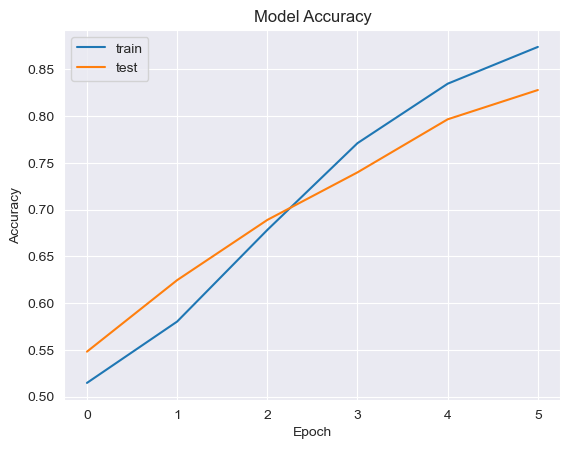

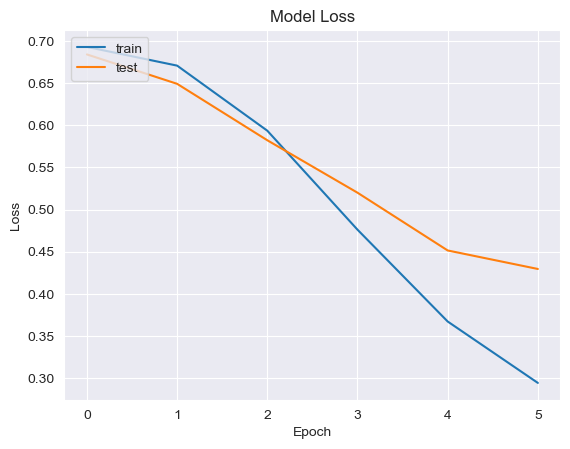

In [129]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [134]:
cnn_model.save("my_cnn_model.h5")

## Recurrent Neural Network

In [130]:
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential

# Define the model
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=True)
lstm_model.add(embedding_layer)

# Add dropout to prevent overfitting
lstm_model.add(Dropout(0.2))

# Add another LSTM layer for increased complexity
lstm_model.add(LSTM(256, return_sequences=True))
lstm_model.add(Dropout(0.2))

# Add a third LSTM layer for increased complexity
lstm_model.add(LSTM(128))
lstm_model.add(Dropout(0.2))

# Add a dense layer with sigmoid activation for binary classification
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [131]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          1219700   
                                                                 
 dropout_12 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 256)          365568    
                                                                 
 dropout_13 (Dropout)        (None, 100, 256)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                

In [132]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=1, verbose=1, validation_split=0.2)

169/357 [=============>................] - ETA: 3:09 - loss: 0.6937 - acc: 0.5025

KeyboardInterrupt: 

In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [135]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('my_cnn_model.h5')

# Create a TFLiteConverter object
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Specify the input and output tensors
converter.input_shape = [None, 224, 224, 3]
converter.output_shape = [None, 1]

# Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Save the model to a file
with open('my_cnn_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\neram\AppData\Local\Temp\tmp0eewf80p\assets


INFO:tensorflow:Assets written to: C:\Users\neram\AppData\Local\Temp\tmp0eewf80p\assets
